1.15.2
Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


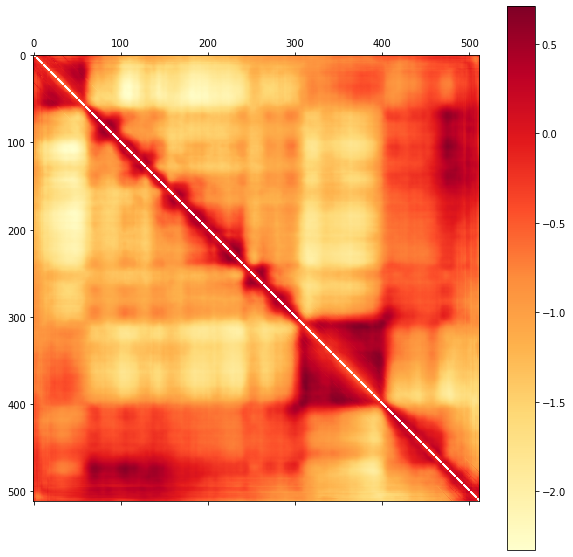

In [1]:
# Run trained model

import matplotlib.pyplot as plt
import numpy as np
import random
import tensorflow as tf
from cooltools.lib.numutils import set_diag
from Bio import SeqIO

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

from models import advanced_2d_cnn

# should be version 1.x
print(tf.__version__)

# the following directive activates inline plotting
%matplotlib inline

# allow to allocate resources for model training
config = tf.ConfigProto(log_device_placement=True)
config.gpu_options.allow_growth = True

from tensorflow.keras.backend import set_session
sess = tf.Session(config=config)
set_session(sess)

# UTIL FUNCTIONS

def plot_hic(matrix, use_log_scale = False, chromosome_position = ()):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111)
    
    if use_log_scale:
        im = ax.matshow(np.log10(matrix), cmap='YlOrRd')
        fig.colorbar(im)
    else:
        im = ax.matshow(matrix, cmap='YlOrRd')
        fig.colorbar(im)
    
    if len(chromosome_position) != 0:
        ax.set_title(f"{chromosome_position[0]}: {chromosome_position[1][0]}-{chromosome_position[1][1]}", fontsize=25)

        
def from_upper_triu(vector_repr, matrix_len = 512, num_diags = 2):
    z = np.zeros((matrix_len,matrix_len))
    triu_tup = np.triu_indices(matrix_len,num_diags)
    z[triu_tup] = vector_repr[0, :, 0]
    
    for i in range(-num_diags+1,num_diags):
        set_diag(z, np.nan, i)
        
    return z + z.T


def one_hot_dna(sequence):
    seq_array = np.array(list(sequence))

    label_encoder = LabelEncoder()
    integer_encoded_seq = label_encoder.fit_transform(seq_array)

    integer_encoded_seq = integer_encoded_seq.reshape(len(integer_encoded_seq), 1)

    onehot_encoder = OneHotEncoder(sparse = False)
    result = onehot_encoder.fit_transform(integer_encoded_seq)

    # if Ns are present in the DNA sequence, result will have 5 columns. We delete 4th column which has Ns
    # N row in the resulting training set will have all 0s
    if result.shape[1] == 5:
        result = np.delete(result, 3, 1)

    return result

######################### 
# Advanced 2D CNN Model
#########################

advanced_model = advanced_2d_cnn.Model().get_model()

# Load best weights from augmented training
advanced_model.load_weights("./weights/v2/model_80_epochs.h5")

# Read DNA sequence from a fasta file
# Sequence should be 526.000 nucleotides long

FASTA_FILENAME = 'dna_seq_example'
dna_seq = str(list(SeqIO.parse(open(f"./{FASTA_FILENAME}.fa"),'fasta'))[0].seq).upper()

# one hot encode
dna_seq_one_hot = one_hot_dna(dna_seq)

# crop and prepare dna for the model
dna_seq_one_hot = dna_seq_one_hot[856:(526000 - 856), :].reshape(1, 524288, 4)

dna_seq_one_hot.shape

# Predict
prediction = advanced_model.predict(dna_seq_one_hot)

# Plot Hi-C
plot_hic(from_upper_triu(prediction))

In [9]:
advanced_model.layers[6]

In [16]:
np.array(advanced_model.layers[4].get_weights()).shape

(0,)

In [120]:
conv2d_layers = [layer for layer in advanced_model.layers if 'Conv2D' in str(layer)]

In [121]:
layer_outputs = [layer.output for layer in conv2d_layers]
activation_model = tf.keras.Model(inputs=advanced_model.input, outputs=layer_outputs)

In [122]:
activations = activation_model.predict(dna_seq_one_hot) 

In [123]:
len(activations)

13

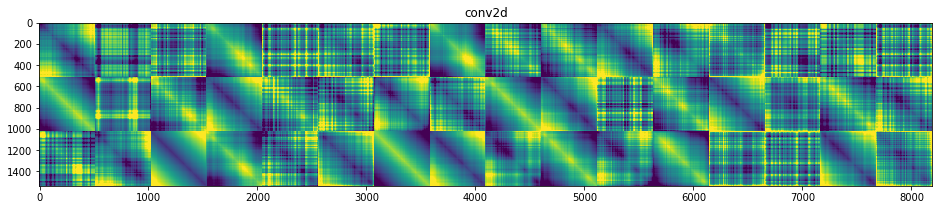

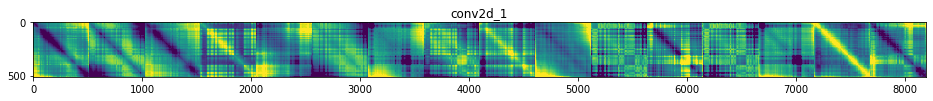

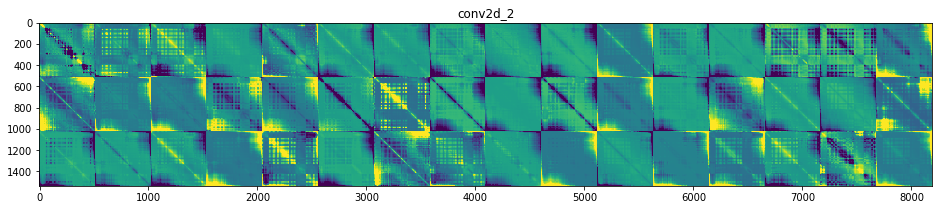

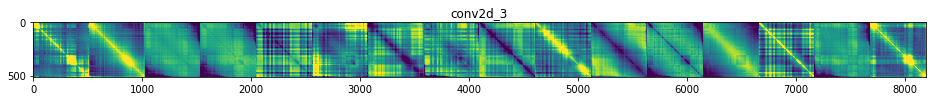

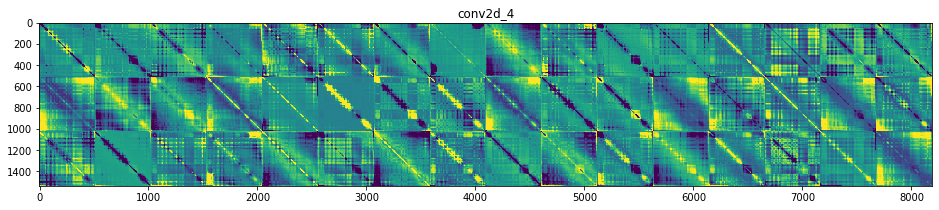

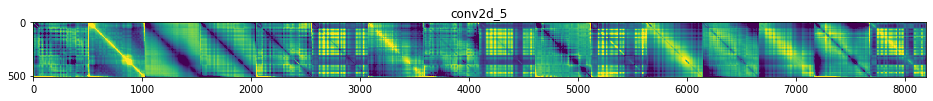

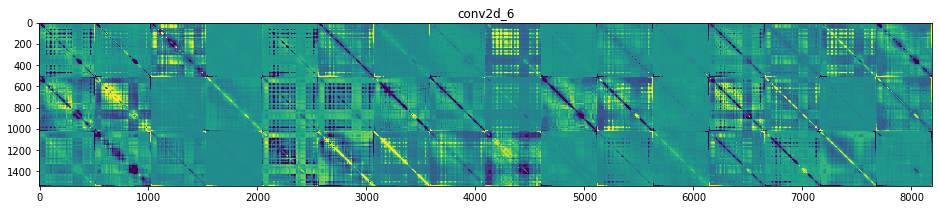

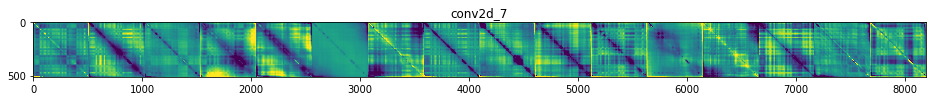

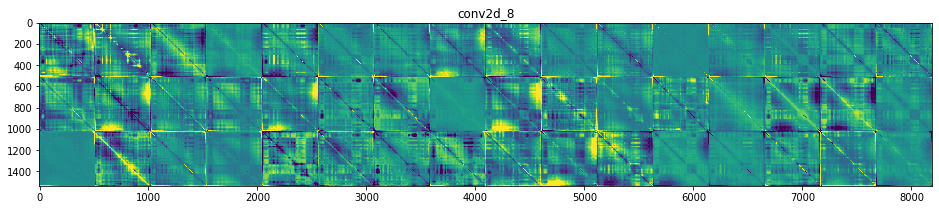

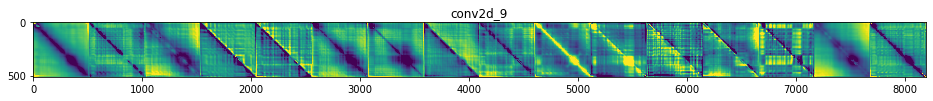

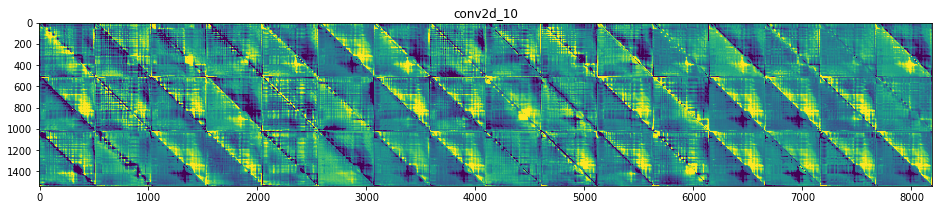

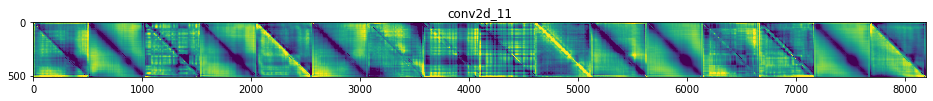

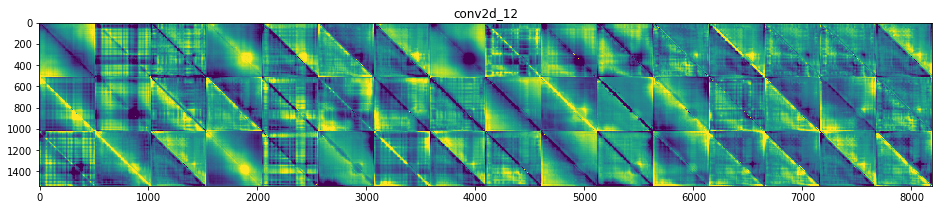

In [125]:
layer_names = []
for layer in conv2d_layers:
    layer_names.append(layer.name)
    
images_per_row = 16

for layer_name, layer_activation in zip(layer_names, activations):
    n_features = layer_activation.shape[-1] # Number of features in the feature map
    size = layer_activation.shape[1] #The feature map has shape (1, size, size, n_features).
    n_cols = n_features // images_per_row # Tiles the activation channels in this matrix
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    for col in range(n_cols): # Tiles each filter into a big horizontal grid
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size, # Displays the grid
                         row * size : (row + 1) * size] = channel_image
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')